# La présence de bibliothèques autour des lycées augmente-t-elle la performance des lycées ?

In [1]:
# Setup

# Si la commande n'avait pas déjà été lancée danas le terminal
!pip install -r "requirements.txt"

import numpy as np
import pandas as pd
import geopandas as gpd
from src.download_file import download_file
from src.data_lycees import get_data_lycees
from src.data_lycees import merge_data_lycees
from src.data_biblio import get_data_biblio
from src.calcul_biblio_rayons import calcul_biblio_rayons
from src.calcul_distance import calcul_distance
from src.classe_modelisation import PipelineRegression
import matplotlib.pyplot as plt
from plotnine import *
import folium

pd.set_option('display.width', 140)

### Contexte

La performance des lycées est ici entendue comme le taux de réussite à l’examen du 
baccalauréat général, même si l’étude du taux de mention obtenu par les lycées est 
une piste envisagée. Celle-ci peut être expliquée par trois facteurs :

-	par le public de l’établissement (les élèves et leur origine sociale)
-	par le contexte de l’établissement (ses propriétés intrinsèques et possiblement les politiques 
    éducatives dont il fait objet)
-	par l’environnement de l’établissement (ce qui est relatif à sa situation géographique)

La question que l’on se pose se concentre sur les facteurs environnementaux de réussite scolaire, 
en proposant l’analyse de l’impact de la présence de bibliothèques autour des lycées. Les 
bibliothèques, qu’elles soient municipales, universitaires ou d’une autre nature, sont en effet 
des lieux qui peuvent favoriser la réussite des élèves par au moins deux moyens : d’abord, ce 
sont des lieux d’accès à la culture et à la connaissance ; d’autre part, ce sont aussi des 
lieux de révision privilégiés, notamment pour la préparation du baccalauréat .

La démarche adoptée consiste donc principalement à étudier le lien entre proximité d’une (ou de) 
bibliothèque(s) et performance des lycées. Cette proximité sera évaluée par la distance 
géographique, ou aussi par le nombre d’équipements disponibles dans un rayon donné. 


### Méthodes

@bourdieuHeritiersEtudiantsCulture1964

Après quelques statistiques descriptives et cartes pour illustrer le problème, des régressions 
linéaires seront mobilisées pour tester notre hypothèse, en contrôlant par d’autres variables. En 
partant des facteurs mis en évidence précédemment, la composition sociale du lycée sera appréciée 
à partir de l’indice de position sociale proposée par la Depp (cf. rubrique « Données »). Le 
contexte de l’établissement sera surtout pris en compte par le secteur de l’établissement 
(privé / public) et les filières et formations disponibles en son sein (filières technologiques 
et professionnelles, formations post-baccalauréat comme les BTS ou CPGE).

### Données

Pour ce qui est des données mobilisées, l’échelle d’observation sera le lycée. Le champ d’étude 
est limité aux lycées avec au moins 50 candidats (seuil à préciser) présents aux épreuves du 
baccalauréat général en 2024. Il s’agira alors de construire nos observations à partir de 
trois bases de données ouvertes produites par la Depp (service statistique ministériel de 
l’Education nationale) :
-	taux de réussite et de mention au bac (https://data.education.gouv.fr/explore/dataset/fr-en-indicateurs-de-resultat-des-lycees-gt_v2/information/)
-	indice de position sociale (https://data.education.gouv.fr/explore/dataset/fr-en-ips-lycees-ap2023/information/)
-	géolocalisation des lycées (https://data.education.gouv.fr/explore/dataset/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre/information/)

Enfin, le choix de se limiter à 2024 est lié à la disponibilité des données concernant les 
bibliothèques. En effet, nous utilisons la base permanente des équipements, qui n’est disponible 
en open data que pour 2024 (https://www.data.gouv.fr/datasets/base-permanente-des-equipements-1/).


## Analyse descriptive des données

### Les données sur les lycées

In [2]:
# Importation des données sur les lycées

lycees_resultats, lycees_ips, annuaire_education = get_data_lycees()
lycees_data = merge_data_lycees(lycees_resultats, lycees_ips, annuaire_education)
lycees_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1911 entries, 0 to 2212
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   uai                                 1911 non-null   object  
 1   annee                               1911 non-null   int64   
 2   presents_gnle                       1911 non-null   float64 
 3   taux_reu_gnle                       1911 non-null   float64 
 4   va_reu_gnle                         1910 non-null   float64 
 5   taux_men_gnle                       1911 non-null   float64 
 6   va_men_gnle                         1910 non-null   float64 
 7   ips_voie_gt                         1911 non-null   float64 
 8   ecart_type_voie_gt                  1911 non-null   float64 
 9   libelle_etablissement               1911 non-null   object  
 10  code_commune                        1911 non-null   object  
 11  code_departement           

/opt/python/lib/python3.13/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_density : Removed 2 rows containing non-finite values.


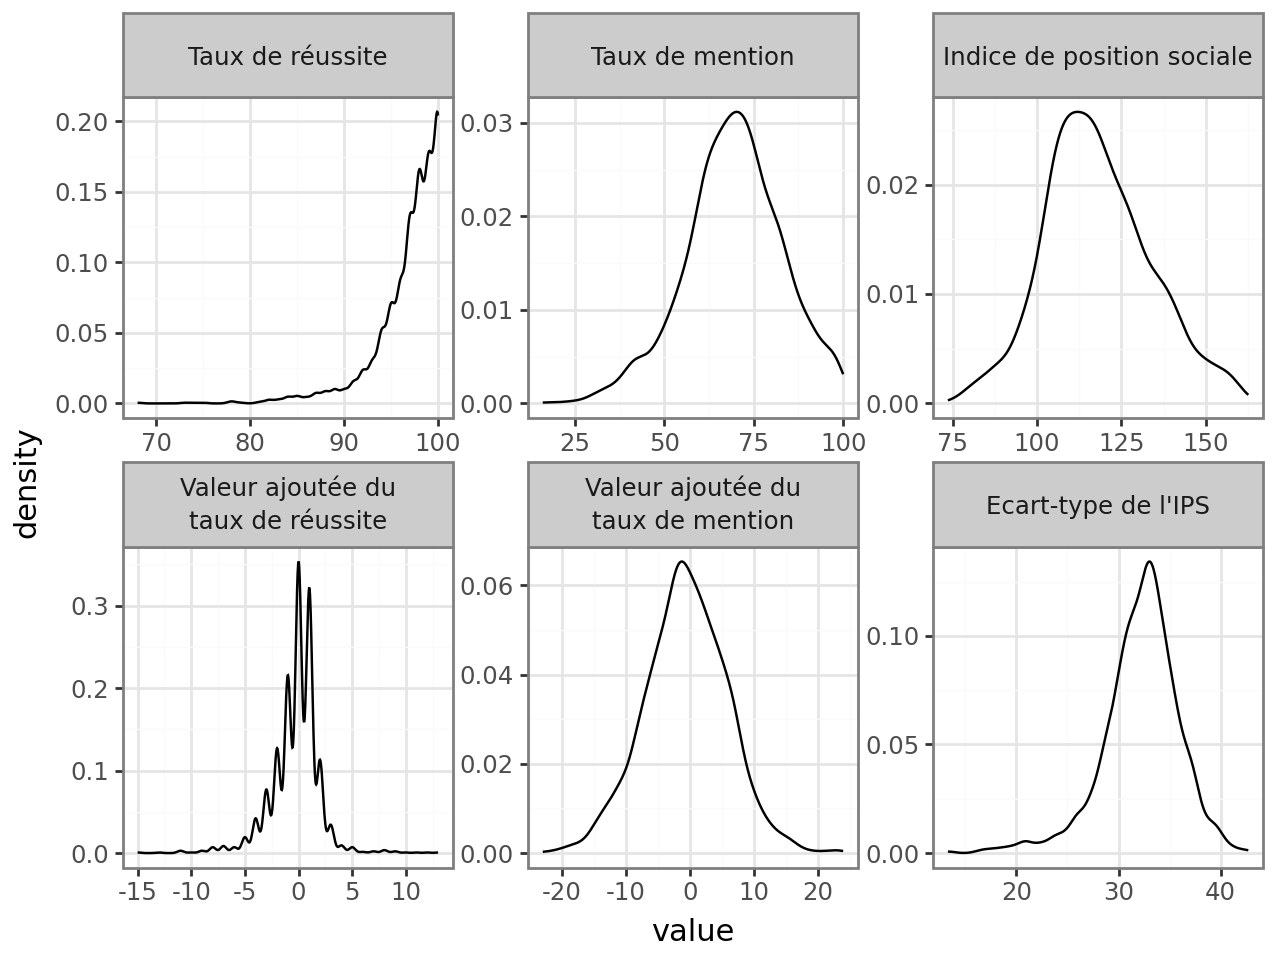

In [3]:
# Stats desc. - Lycées vars numériques

lycees_stat_desc_num = lycees_data.melt(
    id_vars = ['uai'],
    value_vars = [
        'taux_reu_gnle', 'va_reu_gnle', 'taux_men_gnle', 'va_men_gnle',
        'ips_voie_gt', 'ecart_type_voie_gt'
    ]
)#.sort_values('uai').reset_index()

lycees_stat_desc_num['variable'] = pd.Categorical(
    lycees_stat_desc_num['variable'],
    ordered=True,
    categories=[
        'taux_reu_gnle', 'taux_men_gnle', 'ips_voie_gt', 
        'va_reu_gnle', 'va_men_gnle', 'ecart_type_voie_gt'
    ]
).rename_categories([
    'Taux de réussite', 'Taux de mention', 
    'Indice de position sociale', 'Valeur ajoutée du\ntaux de réussite', 
    'Valeur ajoutée du\ntaux de mention', 'Ecart-type de l\'IPS'
])

(
    ggplot(lycees_stat_desc_num) +
    aes(x = 'value') +
    geom_density() +
    facet_wrap('variable', scales ='free') +
    theme_bw()
)

### Les données sur les bibliothèques

In [4]:
# Importation des données sur les bibliothèques

biblio = get_data_biblio()
biblio.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4958 entries, 0 to 5166
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   NOMETAB           4958 non-null   object  
 1   PAYS              4958 non-null   object  
 2   CODEPOSTAL        4958 non-null   object  
 3   LATITUDE          4958 non-null   float64 
 4   LONGITUDE         4958 non-null   float64 
 5   CONDITIONACCES_d  4373 non-null   object  
 6   TYPEETABABES_d    4938 non-null   object  
 7   TYPEFAMABES_d     4936 non-null   object  
 8   TYPEINST_d        4957 non-null   object  
 9   geometry          4958 non-null   geometry
dtypes: float64(2), geometry(1), object(7)
memory usage: 426.1+ KB


### Croiser les données des lycées et des bibliothèques

Après avoir considéré séparément les données des lycées et des bibliothèques, il faut maintenant les
faire se rencontrer. Une première façon de le faire est de proposer une interprétation graphique du 
problème soulevé par ce projet. Pour cela, illustrons-le à l'aide d'une carte où sont représentés à
la fois les lycées et les bibliothèques. Par simplicité, nous nous concentrerons ici sur le cas de 
la ville de Paris.

In [5]:
# Carte lycées & bibliothèques

lycees_75 = lycees_data[lycees_data['code_departement'] == "075"]
biblio_75 = biblio[biblio['CODEPOSTAL'].str[0:2] == "75"]

center = [biblio_75.LATITUDE.mean(), biblio_75.LONGITUDE.mean()]
m = folium.Map(
    location=center, 
    zoom_start=12
    )

tooltip = folium.GeoJsonTooltip(
    fields=['NOMETAB', 'TYPEETABABES_d', 'CONDITIONACCES_d'],
    aliases=['Nom :', 'TYPEETABABES : ', 'CONDITIONACCES_d :'],
    localize=True
)
folium.GeoJson(
    biblio_75,
    tooltip=tooltip, 
    marker=folium.Marker(icon=folium.Icon(color="green")),
).add_to(m)

tooltip = folium.GeoJsonTooltip(
    fields=['libelle_etablissement', 'statut_public_prive', 'presents_gnle', 'taux_reu_gnle', 'taux_men_gnle', 'ips_voie_gt'],
    aliases=[
        'Nom :', 'Secteur :', 'Nombre de candidats présents :', 'Taux de réussite :', 'Taux de mention',
        'Indice de position sociale :'
    ],
    localize=True
)
folium.GeoJson(
    lycees_75,
    tooltip=tooltip, 
    marker=folium.Marker(icon=folium.Icon(color="blue")),
).add_to(m)

m

interprétation de la carte

In [6]:
# Calculs - Distance à la bibliothèque la plus proche

lycees_data = calcul_distance(lycees_data, biblio)


La distance à la bibliothèque la plus proche

[np.float64(0.0), np.float64(0.1), np.float64(0.2), np.float64(0.30000000000000004), np.float64(0.4), np.float64(0.5), np.float64(0.6000000000000001), np.float64(0.7000000000000001), np.float64(0.8), np.float64(0.9), np.float64(1.0)]
[    0   179   281   381   495   653   845  1073  1474  3619 38873]


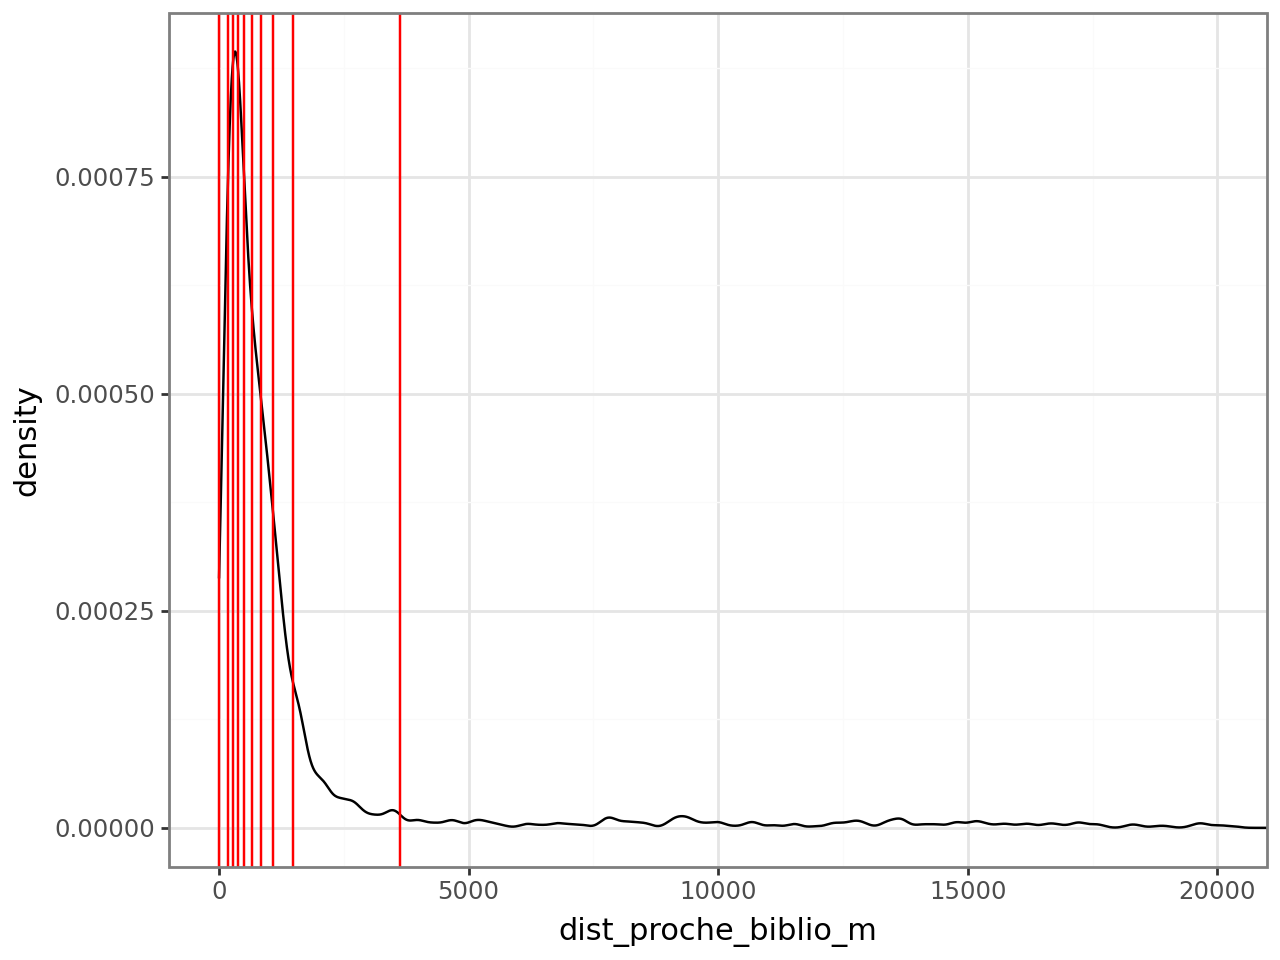

In [7]:
# Stats desc. - Distance à la bibliothèque la plus proche

probs = list(np.arange(0, 1.1, 0.1))
temp_quantile = np.quantile(lycees_data['dist_proche_biblio_m'], q = probs)
temp_quantile = np.quantile(lycees_data['dist_proche_biblio_m'], q = probs)
print(probs)
print(temp_quantile.round().astype(int))
(
    ggplot(lycees_data) +
    geom_density(aes(x = 'dist_proche_biblio_m'), n = 10000) + 
    coord_cartesian(xlim = [0, 20000]) +
    geom_vline(xintercept=temp_quantile.tolist(), color="red") +
    theme_bw()
)

Interprétation

In [8]:
# Calculs - Présence et nombre de bibliothèques à proximité

lycees_data = calcul_biblio_rayons(lycees_data, biblio)

lycees_data = lycees_data.assign(
    dummy_biblio_500 = lycees_data['nb_biblio_500'] > 0,
    dummy_biblio_1000 = lycees_data['nb_biblio_1000'] > 0,
    dummy_biblio_2000 = lycees_data['nb_biblio_2000'] > 0,
    dummy_biblio_5000 = lycees_data['nb_biblio_5000'] > 0,
)


La présence et le nombre de bibliothèques à proximité

In [9]:
# Stats desc. - Présence et nombre de bibliothèques à proximité

(
    lycees_data
    .groupby(['dummy_biblio_500', 'dummy_biblio_1000', 'dummy_biblio_2000', 'dummy_biblio_5000'])
    .size()
    .div(lycees_data.shape[0])
    .mul(100)
)

dummy_biblio_500  dummy_biblio_1000  dummy_biblio_2000  dummy_biblio_5000
False             False              False              False                 9.035840
                                                        True                  5.451792
                                     True               True                 18.677436
                  True               True               True                 26.400808
True              True               True               True                 40.434124
dtype: float64

In [10]:
# Stats desc. - Présence et nombre de bibliothèques à proximité

pd.crosstab(
    lycees_data['libelle_region'],
    lycees_data['dummy_biblio_5000']
    )

dummy_biblio_5000,False,True
libelle_region,,
Auvergne-Rhône-Alpes,38,230
Bourgogne-Franche-Comté,2,80
Bretagne,17,87
Centre-Val de Loire,1,60
Grand Est,10,160
Hauts-de-France,10,157
Ile-de-France,11,424
Normandie,7,87
Nouvelle-Aquitaine,24,141


Interprétation

## Modélisation

In [11]:
print(PipelineRegression.__doc__)


Pipeline de modélisation de régression linéaire avec visualisations avancées.

Cette classe implémente une approche structurée et reproductible pour la
modélisation statistique, inspirée des bonnes pratiques en science des données.

Attributs
---------
X : array-like
    Variables explicatives standardisées
y : array-like
    Variable cible
model : statsmodels.regression.linear_model.RegressionResultsWrapper
    Modèle statistique ajusté
scaler : StandardScaler
    Standardiseur pour les variables explicatives
standardisation : bool
    Indicateur de standardisation des données

Références (Travaux de Lino Galiana)
------------------------------------
- https://pythonds.linogaliana.fr
- https://doi.org/10.5281/zenodo.8229676



In [12]:
data = lycees_data.copy()
features = ["ips_voie_gt", "statut_public_prive","nb_biblio_500"]
target = "taux_men_gnle"

In [13]:
model = PipelineRegression()

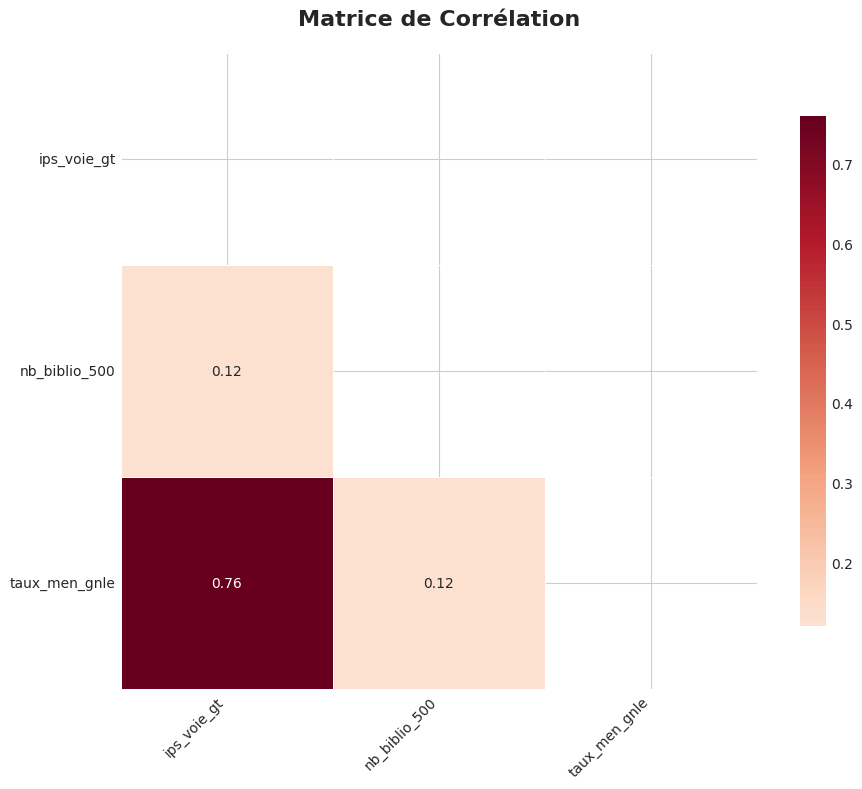

In [14]:
fig_1 = model.heatmap_matrix(data=data , features=features , target=target)
plt.show()

<Figure size 1200x1000 with 0 Axes>

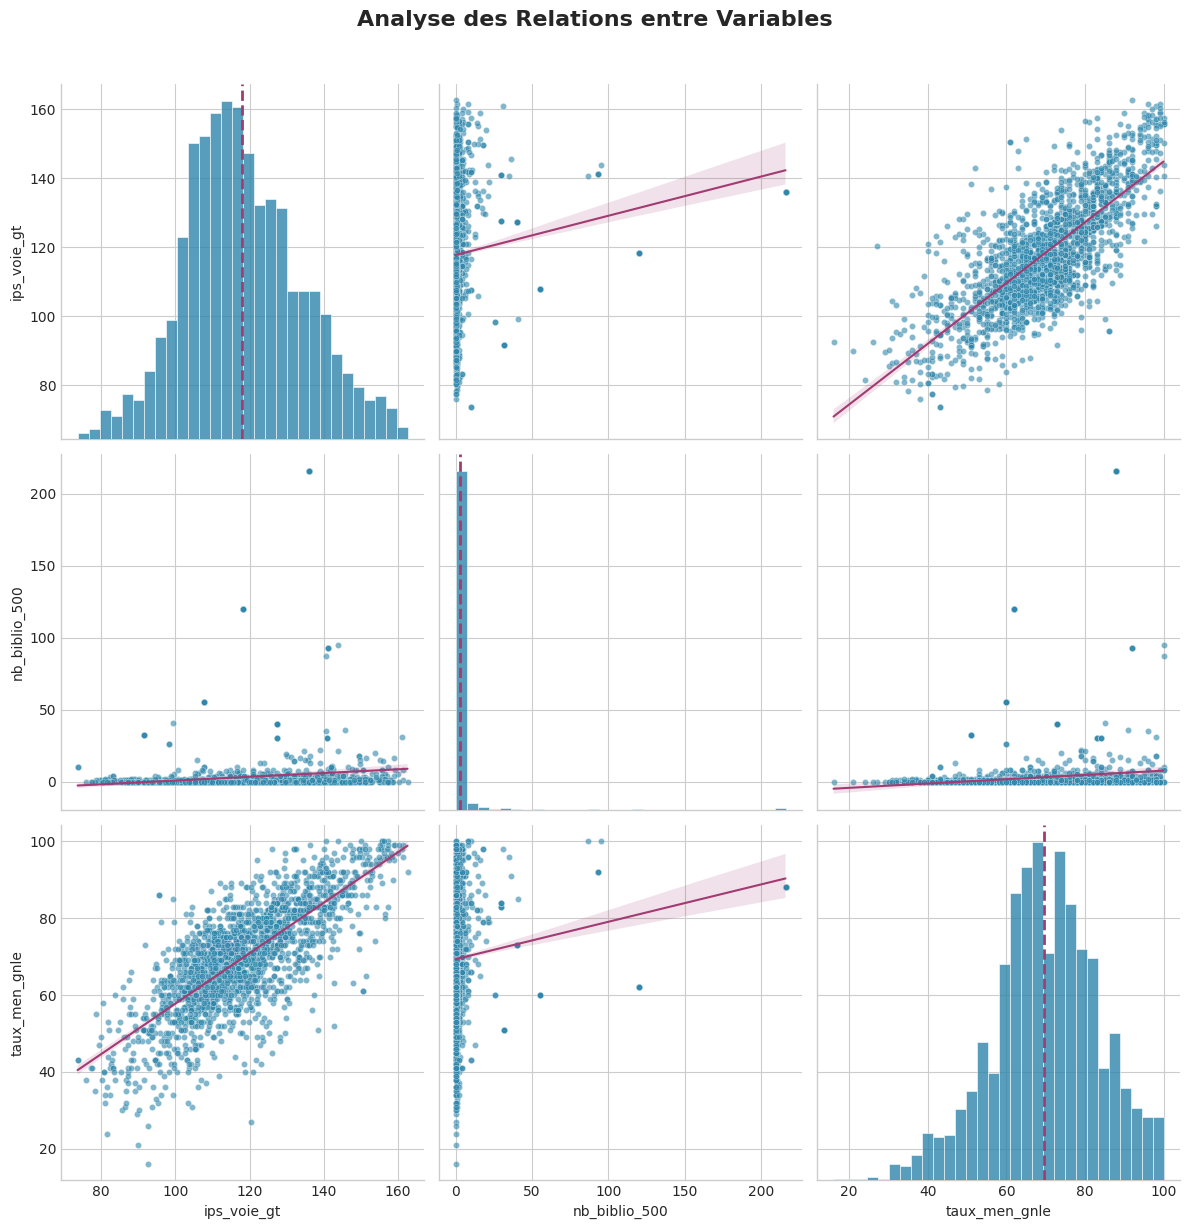

In [15]:
fig_2 = model.paires_plot(data=data , features=features , target=target)
plt.show()

In [16]:

model.fit(data=data , features=features , target=target , include_robust=True , standardisation=True)

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     931.6
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:34:36   Log-Likelihood:                -7107.4
No. Observations:                1981   AIC:                         1.422e+04
Df Residuals:                    1977   BIC:                         1.425e+04
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

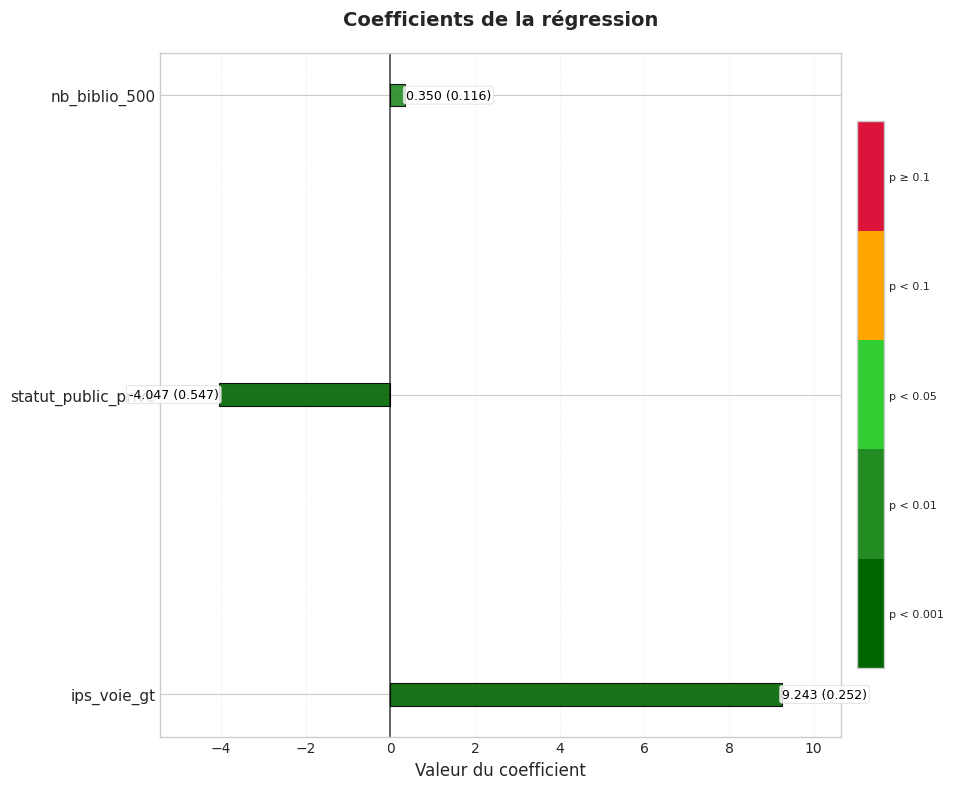

In [17]:
fig3 = model.plot()
plt.show()

## Conclusion

### Perspectives